<a href="https://colab.research.google.com/github/zenodante/AFMTools/blob/master/3DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation

Now that drift correction is complete, we can prepare the images to feed through the machine learning model.  This notebook will demonstrate cropping images, rotating images, and making new arrays of images. The goal here is to take a small number of full images and produce a large number of unique training images.

In many cases, deep learning is not possible or produces inaccurate results due to a lack of available training data. Data availability can often be limited by the time and expense required to manually process and extract important information from images. On the other hand, in image analysis cases where ample data is provided, manually providing ground truth data can be very tedious and expensive. In situ Transmission Electron Microscopy provides a prime example of this, where modern direct detection cameras can collect hundreds or thousands of images per second yet quantifying the information in these images is extremely difficult. Convolutional neural networks have been shown to be extremely effective for segmenting electron microscopy images, but the amount of data required for training can often be prohibitive. By preparing a training set with built-in data augmentation, we can reduce the initial cost of developing a machine learning model, and significantly decrease the time required to move from raw data to fully segmented images.

## Import necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import filters, transform, util
import os

Randomly choose and some number of the images. 
<font color='green'>

ACTION : Change the number in `np.arrange()` to the number of images in the dataset. Then load the drift-corrected images with the specified random indexes.</font> 

In [ ]:
!gdown --id 1ToMKj2aXO__qT1GisyTXaVjsOCG4elFF
images = np.load('/content/sample_driftcorrect.npy',mmap_mode='r+')

In [ ]:
num_images = 50  
c = np.random.choice(np.arange(1000),num_images) 

!gdown --id 1ToMKj2aXO__qT1GisyTXaVjsOCG4elFF
images = np.load('/content/sample_driftcorrect.npy',mmap_mode='r+')[c]

## Data Augmentation

Data augmentation allows us to use the available data to increase the amount of data that can be used for training.  Random changes in brightness, contrast, and feature position mean that all images are unique, and therefore simple operations such as rotating and cropping the image produce even more unique images. 

We will start by rotating images in increments of 90 degrees to produce a four-fold increase in the size of the dataset. Use the `skimage.transform.rotate` function to rotate images by the specified amount. Store the rotated images in the array `rotated_images`. 

In [ ]:
rotate = [90,180,270] 
rotated_images = np.zeros((len(images)*len(rotate),images.shape[1],images.shape[2])) 

n = 0
for i in range(len(images)):
    if i % 50 == 0:
        print('{} / {}'.format(i,len(images)))
    for j in rotate:
        rotated_images[n] = transform.rotate(images[i],j) 
        n += 1

0 / 100
50 / 100


The shape of `rotated_images` should be (300, drift corrected y, drift corrected x) and the shape of `images` should be (100, drift corrected y, drift corrected y).



In [ ]:
print(rotated_images.shape)
print(images.shape)

(300, 3072, 3072)
(100, 3072, 3072)


We then want to combine the original `images` with the `rotated_images` using `np.concatenate`. The shape of `all_images` should be (400, drift corrected y, drift corrected x)

<font color='green'>ACTION: may need to restart kernel.</font>

As the size of the data set increases, it will eventually exceed the available RAM on the computer.  Numpy has a feature for loading datasets `np.load(mmap_mode='r+')`, that loads memory addreses rather than full images to save RAM. After saving the dataset to disk, we can reload the address information of the data we just saved rather than the full image data.

<font color='red'> Do not save and reload data if you are using the provided sample data

In [ ]:
all_images = np.concatenate((images,rotated_images),axis=0) 
print(all_images.shape)
np.save('800C_video_float32_intermediate2.npy',all_images) 

(400, 3072, 3072)


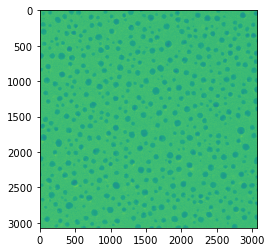

In [ ]:
all_images = np.load('800C_video_float32_intermediate2.npy',mmap_mode='r+')  

## Image Cropping

Now that we have rotated images, we can crop them into smaller sections as well.  There are two benefits to this:
1. Increase the size of the dataset
2. Decrease the size of an image - this makes processing faster and uses fewer computing resources during a training epoch

As you might expect, there is already a function to break down an image into component parts: `skimage.util.view_as_windows`.  This tool uses a sliding window and breaks an image down into unique sections of the window size. We break an image `all_images[i]` into 512x512 components, using 512 step size in each direction so that images don't overlap. Note: if few training images are available, overlapping windows will still produce unique training examples.  

You need to find out how many 512 x 512 images can be created from one image based on the size of the image. This will be unique for each dataset depending on how much you need to crop to account for sample drift. To do this determine how many factors of 512 can go into the drift corrected y value and how many factors of 512 can go into the drift corrected x value. Multiply these two numbers together and that is the number of cropped images you can get from each image in `all_images`. 

<font color='green'>ACTION: this number should be entered as num.</font>

In [ ]:
num = 36
all_image_sections = np.zeros((len(all_images) * num,512 ,512)) 

n = 0
for i in range(len(all_images)):
    if i % 50 == 0: 
        print(i)
    B = util.view_as_windows(all_images[i],window_shape=(512,512),step=512) 
    B = B.reshape(-1,512,512) 
    all_image_sections[n*num:n*num + num] = B  
    n += 1

0
50
100
150
200
250
300
350


## Intensity Normalization

Even though images were previously scaled and normalized, the previous maximum or minimum pixel value of the entire image may not be contained in the cropped image.  Therefore, the images must be re-normalized so that all training images will be in the range 0 to 1.

In [ ]:
def scale(im):
    return (im - np.mean(im)) / np.std(im)

def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im))

for i in range(len(all_image_sections)):
    all_image_sections[i] = norm(scale(all_image_sections[i]))

Now the training set is complete.  Save it and move on to the image segmentation step.

<font color='red'> Do not save the dataset if you are using the provided sample data.

In [ ]:
np.save('training_set_800C_video_float32.npy',all_image_sections)